# 实用python编程系列：互联网应用

本节介绍如何利用python实现一个基于标签的图像搜索引擎

* matplotlib查看特定图像
* 写一个python类（class）实现图像搜索引擎涉及的关键方法（索引、查询）

In [1]:
%pylab inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


给定图像id，返回它的图像文件路径

In [2]:
def get_img_path(imageid):
    img_path = os.path.join(os.environ['HOME'], 'VisualSearch', 'flickr10k', 'ImageData', imageid[-1], '%s.jpg' % imageid)
    return img_path

imset = '3949407308 4528159441'.split()
for imageid in imset:
    print imageid, get_img_path(imageid)

3949407308 /Users/xirong/VisualSearch/flickr10k/ImageData/8/3949407308.jpg
4528159441 /Users/xirong/VisualSearch/flickr10k/ImageData/1/4528159441.jpg


用mpimg.imread方法从磁盘中读取图像，并用imshow方法显示。

(332, 500, 3)


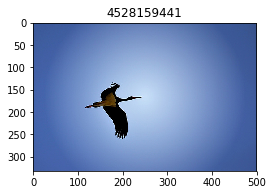

In [3]:
imageid = '4528159441'
local_filename = get_img_path(imageid)
img = mpimg.imread(local_filename)
print img.shape
fig, ax1 = plt.subplots(figsize=(4,4))
imgplot = ax1.imshow(img)
ax1.set_title(imageid)

同时显示多张图像

2 2


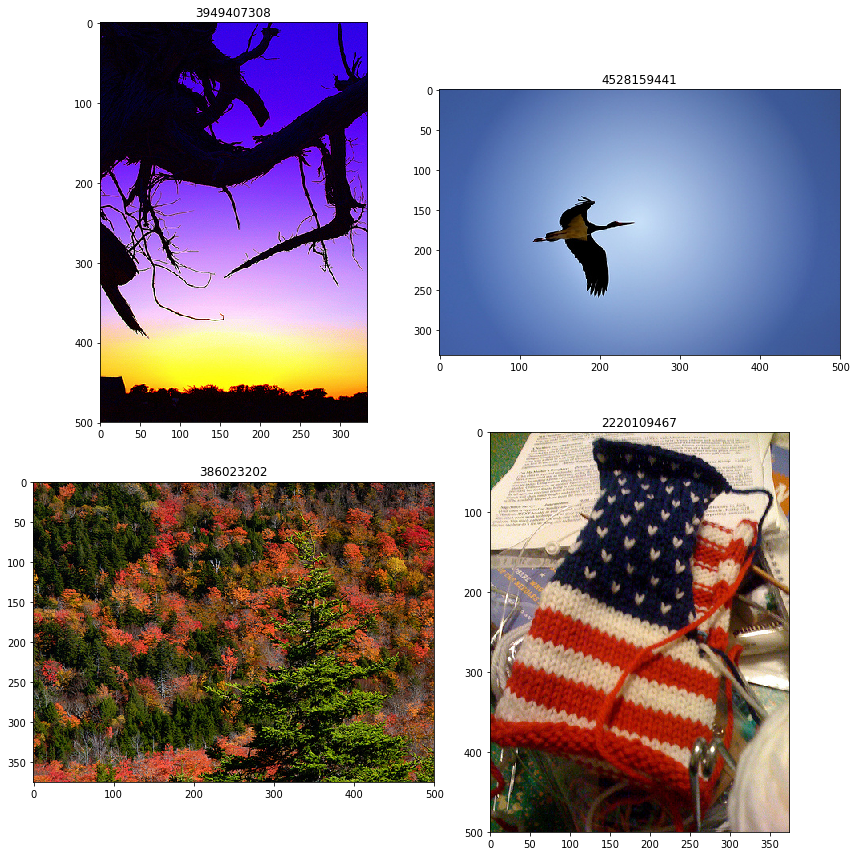

In [4]:
imset = '3949407308 4528159441 386023202 2220109467'.split()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
max_row, max_col = axes.shape
print max_row, max_col

for i in range(max_row):
    for j in range(max_col):
        ax = axes[i][j]
        img_path = get_img_path(imset[i*max_col+j])
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(imset[i*max_col+j])
        #plt.setp(ax.get_xticklabels(), visible=False)
        #ax.xaxis.set_tick_params(size=0)
        #plt.setp(ax.get_yticklabels(), visible=False)
        #ax.yaxis.set_tick_params(size=0)
fig.tight_layout()

## 基于标签搜索图像

给定一个查询标签（query tag），找到所有带有该标签的图像。
一个简单的方案就是扫描标签文件的每一行，如果该行包含query tag，则记录该图像id。
实现如下：

In [5]:
import time

def search(query, tagfile):
    s_time = time.time()
    hitlist = []
    for line in open(tagfile):
        imageid, userid, tags = line.strip().split('\t') # tab character as separator
        tagset = set(tags.split())
        if query in tagset:
            hitlist.append(imageid)
    timecost = time.time() - s_time
    return {'content':hitlist, 'time':timecost}

tagfile = '/Users/xirong/VisualSearch/flickr10k/TextData/id.userid.rawtags.txt'
results = search('dog', tagfile)
print '%d hits, %.4f seconds' % (len(results['content']), results['time'])

209 hits, 0.0576 seconds


显示前4张图像

2 2


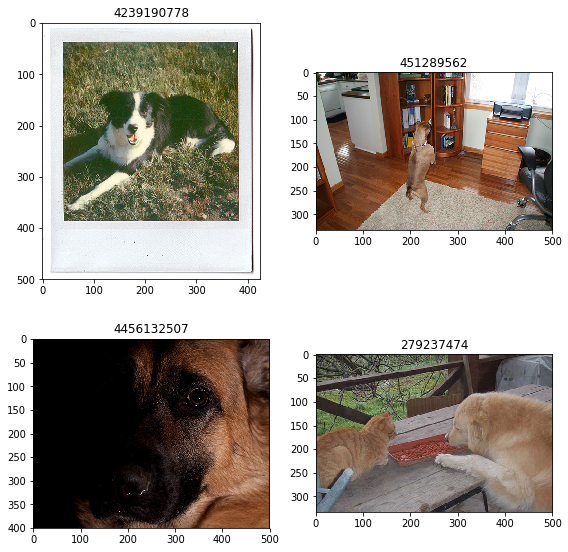

In [6]:
imset = results['content'][:4]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
max_row, max_col = axes.shape
print max_row, max_col

for i in range(max_row):
    for j in range(max_col):
        ax = axes[i][j]
        img_path = get_img_path(imset[i*max_col+j])
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(imset[i*max_col+j])
        #plt.setp(ax.get_xticklabels(), visible=False)
        #ax.xaxis.set_tick_params(size=0)
        #plt.setp(ax.get_yticklabels(), visible=False)
        #ax.yaxis.set_tick_params(size=0)
fig.tight_layout()

## 用类 (class) 包装

定义一个ImageSearch类，它的search方法实现我们想要的功能。

In [7]:
class ImageSearch:
    def __init__(self, tagfile):
        self.data = map(str.strip, open(tagfile).readlines())
     
    def search(self, query):
        s_time = time.time()
        hitlist = []
        for line in self.data:
            imageid, userid, tags = line.strip().split('\t') # tab character as separator
            tagset = set(tags.split())
            if query in tagset:
                hitlist.append(imageid)
        timecost = time.time() - s_time
        return {'content':hitlist, 'time':timecost}

searcher = ImageSearch(tagfile)
results = searcher.search('dog')
print '%d hits, %.4f seconds' % (len(results['content']), results['time'])

209 hits, 0.0345 seconds


通过预先建立的倒排表，加速图像搜索。以更多的内存开销换取速度的提升。

In [8]:
class FastImageSearch:
    def __init__(self, tagfile):
        self.im2hitlist = {}
        for line in open(tagfile).readlines():
            imageid, userid, tags = line.strip().split('\t') # tab character as separator
            tagset = set(tags.split())
            for tag in tagset:
                self.im2hitlist.setdefault(tag, []).append(imageid)
        
    def search(self, query):
        s_time = time.time()
        hitlist = self.im2hitlist.get(query, [])
        timecost = time.time() - s_time
        return {'content':hitlist, 'time':timecost}

searcher = FastImageSearch(tagfile)
results = searcher.search('dog')
print '%d hits, %.4f seconds' % (len(results['content']), results['time'])

209 hits, 0.0000 seconds
